In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import cftime

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/isomip'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
SHELF_IC_FILE = 'MOM_Shelf_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [411]:
### Make "smooth" version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def smoothen_ocean1(filename):
    
    isf = xr.open_dataset(di + "/INPUT/Ocean1_3D.nc")
    sli = isf.thick.data[:,:]
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    #print(sli[7,85])
    
    sli[9,70]=(sli[9,69]+sli[9,71])/2  # y = 9
    sli[8,72]=(sli[8,71]+sli[8,73])/2  # y = 8
    sli[6,95]=(sli[6,94]+sli[6,96])/2 # y= 6
    sli[5,97]=(sli[5,96]+sli[5,98])/2 # y= 5
    sli[7,86]=(sli[7,84]+sli[7,88])/2 # y= 7
    sli[7,85]=(sli[7,84]+sli[7,86])/2 # y= 7
    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y= 7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y= 7
    
    sli[5,98]=(sli[5,96]+sli[5,100])/2 #y1=5
    sli[5,97]=(sli[5,96]+sli[5,98])/2  #y1=5

    sli[8,73]=sli[8,73]-(sli[8,73]-sli[8,74])/2 # y1=8
    sli[8,72]=(sli[8,71]+sli[8,73])/2 # y1=8
    sli[8,73]=(sli[8,72]+sli[8,74])/2 # y1 =8

    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y1=7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,87]=(sli[7,85]+sli[7,89])/2 # y1 =7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,86]=(sli[7,85]+sli[7,87])/2 # y1 = 7

    sli[6,96]=(sli[6,95]+sli[6,97])/2 # y1=6
    sli[6,94]=(sli[6,95]+sli[6,93])/2 # y1 =6

    for jj in [4,3,2]:
       sli[jj,97]=(sli[jj,96]+sli[jj,98])/2 #y1=4
    
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=3
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=2

    for jj in [10, 11,12,13,14,15,16,17,18,19]:
        sli[jj,70]=(sli[jj,71]+sli[jj,69])/2 #y1=10
    
    #dat[70]=(dat[71]+dat[69])/2 #y1=11
    #dat[70]=(dat[71]+dat[69])/2 #y1=12
    #dat[70]=(dat[71]+dat[69])/2 #y1=13
    #dat[70]=(dat[71]+dat[69])/2 #y1=14
    #dat[70]=(dat[71]+dat[69])/2 #y1=15
    #dat[70]=(dat[71]+dat[69])/2 #y1=16
    #dat[70]=(dat[71]+dat[69])/2 #y1=17
    #dat[70]=(dat[71]+dat[69])/2 #y1=18
    #dat[70]=(dat[71]+dat[69])/2 #y1=19
    
    new_shelf["thick"][:,:] = sli
    
    #print(sli[7,85])
    
    new_shelf.close()    

In [3]:
### Make symmetric version of ice shelf in_filename
### symmetrized version to be stored in out_filename
def symmetrize_iceshelf(in_filename, out_filename):
    
    isf = xr.open_dataset(in_filename)
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(out_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    

In [4]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### (depends on MOM6 output in IC_FILE, ie. use after a run)
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [5]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [376]:
smoothen_ocean1(di + '/INPUT/tmp.nc')

In [378]:
symmetrize_iceshelf(di + '/INPUT/tmp.nc', di + ICE_SHELF_FILE)

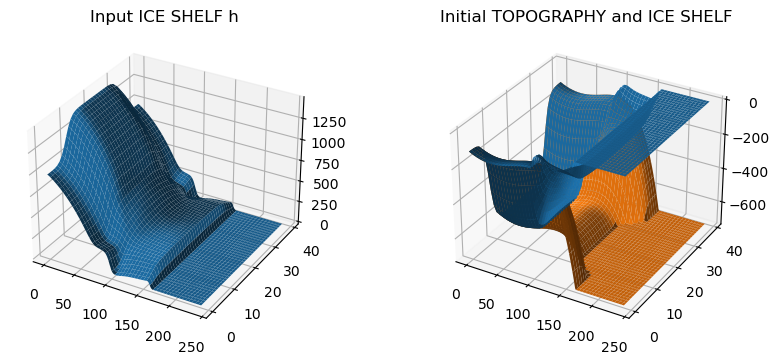

In [489]:
display_config()

In [553]:
make_thickness_file(di + THICKNESS_FILE)

### Plot output h,e,salt etc at chosen time

Text(0.5, 0.98, 'Run time = 5 days, 0:00:00')

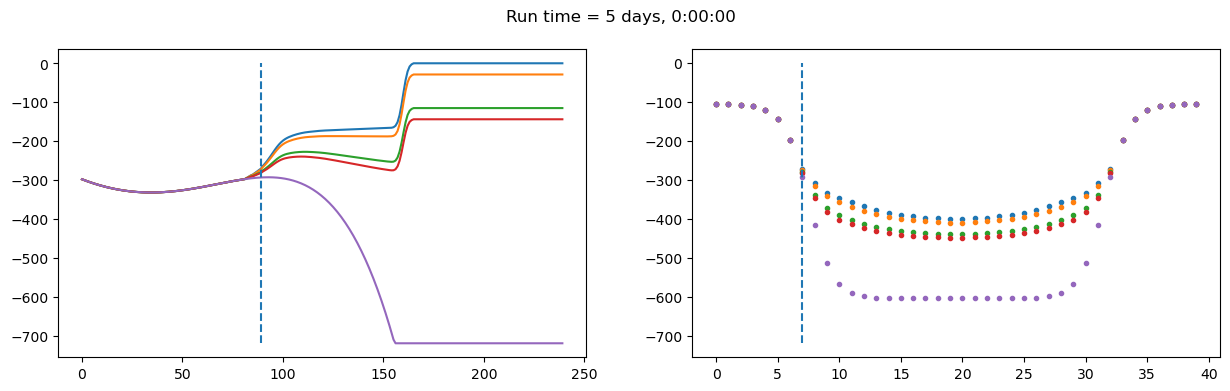

In [569]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
run_time = prog.coords["Time"].values[-1] - cftime.DatetimeJulian(1,1,1)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 4; yy=7; xx=89; ll = [0,1,zz,zz+1,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')
axes[0].vlines(xx, -720, 0, linestyles='dashed')
axes[1].vlines(yy, -720, 0, linestyles='dashed')

fig.suptitle("Run time = {}".format(run_time))

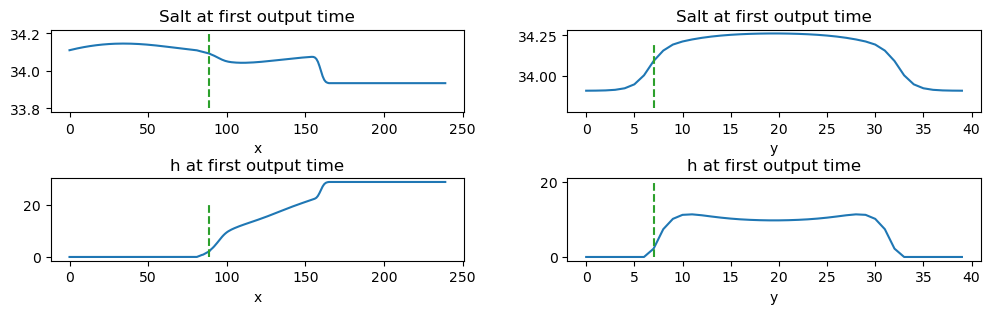

In [568]:
### Can see that the initial salt is "bad" with THICKNESS_CONFIG="ISOMIP" but "fixed" with THICKNESS_CONFIG="thickness_file" hack
ttt = 0; zzz = 4; yyy=7; xxx=89
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,3))
axes[0,0].plot(prog.salt.data[ttt][zzz][yyy,:])
axes[0,0].vlines(xxx, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("Salt at first output time")
axes[0,1].plot(prog.salt.data[ttt][zzz][:,xxx])
axes[0,1].vlines(yyy, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("Salt at first output time")
axes[1,0].plot(prog.h.data[ttt][zzz][yyy,:])
axes[1,0].set_xlabel("x")
axes[1,0].vlines(xxx, 0, 20, linestyles='dashed', colors='C2')
axes[1,0].set_title("h at first output time")
axes[1,1].plot(prog.h.data[ttt][zzz][:,xxx])
axes[1,1].vlines(yyy, 0, 20, linestyles='dashed', colors='C2')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("h at first output time")

plt.subplots_adjust(wspace = 0.25, hspace = 0.8)

In [556]:
np.nanmin(prog.h[0].data)

9.999999886155392e-09

In [557]:
t1 = -1
print(np.nanmax(prog.u.data[t1]), np.nanmin(prog.u.data[t1])) # 0.0012509557073082142 -0.0006301157530793094

0.00031177227227783367 -0.0023249628534782224


In [558]:
print(np.nanmax(prog.v.data[t1]), np.nanmin(prog.v.data[t1])) # 0.0012509557073082142 -0.0006301157530793094

0.0013524175286986444 -0.0013524175286986444


In [567]:
arr = prog.u.data[t1]
ind = np.unravel_index(np.nanargmin(arr),arr.shape)
print(arr[ind])
ind

-0.0023249628534782224


(4, 7, 89)

np.nanmin(prog.e.data[0])

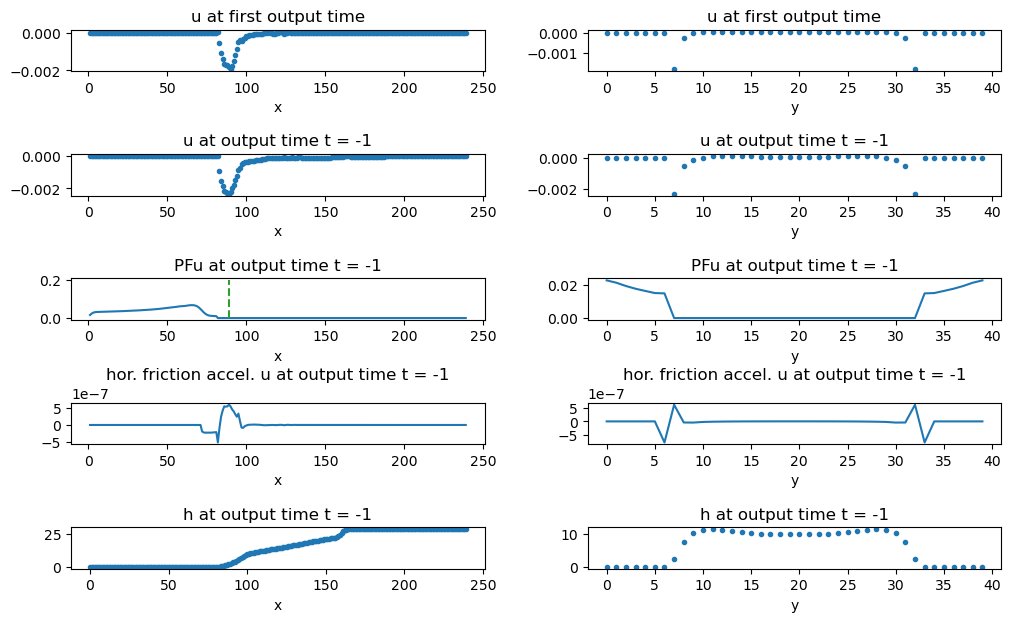

In [570]:
mo = xr.open_dataset(di + '/mom.nc')
fig,axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12,7))

tt=-1; zz=4; yy=7; xx=89
showU = True
if (showU):
    u_or_v = "u"; PFu_or_v = "PFu"; prog_field = prog.u; mo_field = mo.PFu; 
    bt_PFu_or_v = "hor. friction accel. u"; mo_field2 = mo.diffu #mo.u_accel_bt #mo.du_dt_visc
else:
    u_or_v = "v"; PFu_or_v = "PFv"; prog_field = prog.v; mo_field = mo.PFv; 
    bt_PFu_or_v = "hor. friction accel. v"; mo_field2 = mo.diffv #mo.v_accel_bt #mo.dv_dt_visc
    
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("{} at output time t = {}".format(u_or_v, tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("{} at output time t = {}".format(u_or_v,tt))
axes[2,0].plot(mo_field[tt][zz].data[yy,:])
axes[2,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("{} at output time t = {}".format(PFu_or_v,tt))
axes[2,1].plot(mo_field[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("{} at output time t = {}".format(PFu_or_v, tt))
axes[3,0].plot(mo_field2[tt][zz].data[yy,:])
#axes[3,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("{} at output time t = {}".format(bt_PFu_or_v,tt))
axes[3,1].plot(mo_field2[tt][zz].data[:,xx])
axes[3,1].set_xlabel("y")
axes[3,1].set_title("{} at output time t = {}".format(bt_PFu_or_v, tt))
axes[4,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[4,0].set_xlabel("x")
axes[4,0].set_title("h at output time t = {}".format(tt))
axes[4,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[4,1].set_xlabel("y")
axes[4,1].set_title("h at output time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 2.0)

mo.close()

Text(0.5, 1.0, 'forcing at output time t = -1')

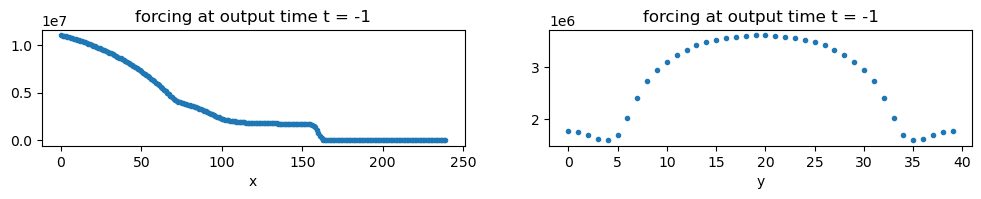

In [561]:
fc = xr.open_dataset(di + '/forcing.nc')

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,1.5))

tt=-1; yy=8; xx=94

#fc_field = fc.taux
#fc_field = fc.tauy
#fc_field = fc.ustar
#fc_field = fc.PRCmE
fc_field = fc.p_surf

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0].plot(fc_field[tt].data[yy,:],'.')
axes[0].set_xlabel("x")
axes[0].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting
axes[1].plot(fc_field[tt].data[:,xx],'.')
axes[1].set_xlabel("y")
axes[1].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting

In [ ]:
! cat input.nml | tail

In [ ]:
! cat diag_table | head

In [575]:
! cat MOM_override | tail -n 25


#override DRAG_BG_VEL = 0.15 ! Default is 0.00
!#override KH = 6.0 ! ISOMIP Asay-Davis protocol, original is 0
#override KH = 1000
#override KV_ML_INVZ2 = 1e-4
#override FIXED_DEPTH_LOTW_ML = True
#override HMIX_FIXED = 2.0

#override SHELF_THREE_EQN = True
#override DEBUG_IS = True

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#override MASS_WEIGHT_IN_PRESSURE_GRADIENT = True
#override BT_THICK_SCHEME = "FROM_BT_CONT"
#override BBL_THICK_MIN = 2.0
#override MIN_THICKNESS = 1e-8

!!!!!!!!!!!!!!!!!  Thickness from  file??   !!!!!!!!

!#override THICKNESS_CONFIG = "ISOMIP"     ! default = "uniform"
#override THICKNESS_CONFIG = "thickness_file"     ! default = "uniform"
#override THICKNESS_FILE = "thickness.nc"     ! default = "uniform"
#override REMAP_AFTER_INITIALIZATION = False
#override HACK_MODE = True


In [ ]:
ice=xr.open_dataset(di + '/' + "ice.nc")
ice

In [ ]:
np.unique(np.concatenate((np.unique(ice.mass_flux[-1].data),
                          np.unique(ice.melt_rate[-1].data),
                         #np.unique(ice.thermal_driving[-1].data),
                         np.unique(ice.haline_driving[-1].data),
                         #np.unique(ice.sbdry[-1].data),
                         #np.unique(ice.u_ml[-1].data),
                         #np.unique(ice.v_ml[-1].data),
                         np.unique(ice.exch_vel_s[-1].data),
                         np.unique(ice.exch_vel_t[-1].data),
                         np.unique(ice.tfreeze[-1].data),
                         np.unique(ice.tflux_shelf[-1].data),
                         #np.unique(ice.ustar_shelf[-1].data)
                         )))

plt.plot(prog.h[0][0].data[8,:],'.')
#plt.xlim([60,90])
#plt.ylim([0,8])

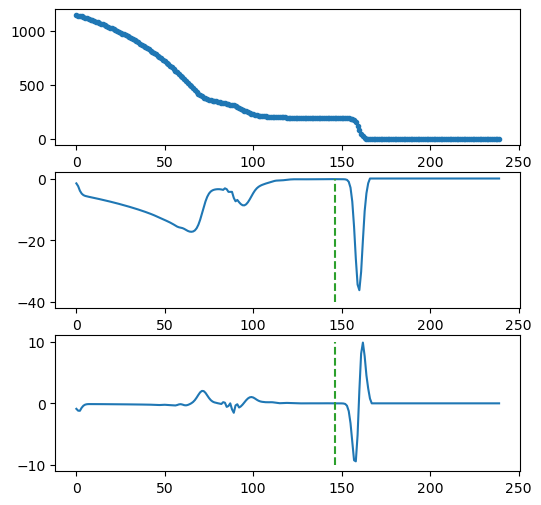

In [484]:
iss=xr.open_dataset(di + ICE_SHELF_FILE)

fig,axes = plt.subplots(nrows = 3, ncols = 1, figsize = (6,6))

y1=7
dat = iss.thick[y1].data

#dat[98]=(dat[96]+dat[100])/2 #y1=5
#dat[97]=(dat[96]+dat[98])/2  #y1=5

#dat[73]=dat[73]-(dat[73]-dat[74])/2 # y1=8
#dat[72]=(dat[71]+dat[73])/2 # y1=8
#dat[73]=(dat[72]+dat[74])/2 # y1 =8

#dat[87]=(dat[86]+dat[88])/2 # y1=7
#dat[88]=(dat[87]+dat[89])/2 # y1 =7
#dat[87]=(dat[85]+dat[89])/2 # y1 =7
#dat[88]=(dat[87]+dat[89])/2 # y1 =7
#dat[86]=(dat[85]+dat[87])/2 # y1 = 7

#dat[96]=(dat[95]+dat[97])/2 # y1=6
#dat[94]=(dat[95]+dat[93])/2 # y1 =6

#dat[97]=(dat[96]+dat[98])/2 #y1=4

#dat[97]=(dat[96]+dat[98])/2 #y1=3

#dat[97]=(dat[96]+dat[98])/2 #y1=2

#dat[70]=(dat[71]+dat[69])/2 #y1=10

#dat[70]=(dat[71]+dat[69])/2 #y1=11

#dat[70]=(dat[71]+dat[69])/2 #y1=12

#dat[70]=(dat[71]+dat[69])/2 #y1=13

#dat[70]=(dat[71]+dat[69])/2 #y1=14

#dat[70]=(dat[71]+dat[69])/2 #y1=15

#dat[70]=(dat[71]+dat[69])/2 #y1=16

#dat[70]=(dat[71]+dat[69])/2 #y1=17

#dat[70]=(dat[71]+dat[69])/2 #y1=18

#dat[70]=(dat[71]+dat[69])/2 #y1=19

#axes[0].set_xlim([80,90])
#axes[0].set_ylim([300,360])
#axes[1].set_xlim([80,90])
#axes[2].set_xlim([90,110])

axes[0].plot(dat, '.')
axes[1].plot(np.gradient(dat))
axes[1].vlines(xx, -40, 0, linestyles='dashed', colors='C2')
axes[2].plot(np.gradient(np.gradient(dat)))
axes[2].vlines(xx, -10, 10, linestyles='dashed', colors='C2')

In [442]:
mo

<xarray.Dataset>
Dimensions:     (xq: 241, yh: 40, zl: 25, Time: 12, xh: 240, yq: 41)
Coordinates:
  * xq          (xq) float64 320.0 322.0 324.0 326.0 ... 794.0 796.0 798.0 800.0
  * yh          (yh) float64 1.0 3.0 5.0 7.0 9.0 ... 71.0 73.0 75.0 77.0 79.0
  * zl          (zl) float64 14.4 43.2 72.0 100.8 ... 619.2 648.0 676.8 705.6
  * Time        (Time) object 0001-01-01 00:05:00 ... 0001-01-01 01:00:00
  * xh          (xh) float64 321.0 323.0 325.0 327.0 ... 793.0 795.0 797.0 799.0
  * yq          (yq) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0 80.0
Data variables:
    dudt        (Time, zl, yh, xq) float64 ...
    dvdt        (Time, zl, yq, xh) float64 ...
    CAu         (Time, zl, yh, xq) float64 ...
    PFu         (Time, zl, yh, xq) float64 ...
    PFv         (Time, zl, yq, xh) float64 ...
    u_accel_bt  (Time, yh, xq) float64 ...
    v_accel_bt  (Time, yq, xh) float64 ...
    diffu       (Time, zl, yh, xq) float64 ...
    diffv       (Time, zl, yq, xh) float64 ...
    du_dt_visc  (Time, zl, yh, xq) float64 ...
    dv_dt_visc  (Time, zl, yq, xh) float64 ...
Attributes:
    filename:   mom.nc
    title:      GOLD Experiment
    grid_type:  regular
    grid_tile:  N/A